<a name="top"></a>
# Predicting Real/Fake News

## 3-Topic-Modelling
---
* [Problem Statement](#Problem-Statement)
* [Executive Summary](#Executive-Summary)
    * [Context](#Context)
    * [Scope](#Scope)
* [Data Dictionary](#Data-Dictionary)
    * [News Topics based on Topic Modelling](#News-Topic-based-on-Topic-Modelling)
* [Importing Libraries](#Importing-Libraries)
    * [Loading Corpus](#Loading-Corpus)
* [Data Cleaning](#Data-Cleaning)
    * [Clean and Tokenize Sentences](#Clean-and-Tokenize-Sentences)
* [Data Processing](#Data-Processing)
* [Build Topic Model](#Build-Topic-Model)
    * [Dominant Topic and Percentage Contribution in Documents](#Dominant-Topic-and-Percentage-Contribution-in-Documents)
    * [Most Representative Sentence for Topics](#Most-Representative-Sentence-for-Topics)
    * [Word Clouds of Key Words in Topics](#Word-Clouds-of-Key-Words-in-Topics)
    * [Word Counts of Topic Key Words](#Word-Counts-of-Topic-Key-Words)
    * [Sentence Chart Coloured by Topic](#Sentence-Chart-Coloured-by-Topic)
    * [Most Discussed Topic in Documents](#Most-Discussed-Topic-in-Documents)
    * [LDA Visualisation](#LDA-Visualisation)
* [Saving Dataframe](#Saving-Dataframe)

## Problem Statement

**To predict real/fake news** based on a kaggle dataset containing various news sources within the US.

## Executive Summary

### Context

Fake news has risen dramatically in popular consciousness over the last few years. According to a Pew Research Center study, Americans deem fake news to be a larger problem than racism, climate change or terrorism. With the advent of social media and the amount of information accessible to us, it is getting increasingly difficult to distinguish between real news and fake news. Therefore, this could have severe repercussions within society if the problem is not dealt with. 

### Scope

The goal of this project was to come up with a model that distinguishes real and fake news using a kaggle data set that contains real news and fake news based on US news outlets. In order to tackle the problem of fake news, several classification models such as the Logistic Regression and Decision trees were applied. It is worth pointing out that the data set is limited in terms of its time frame where news was collated between 2015 and 2018 and also only based on US news outlets. However, the model that has been trained can certainly be helpful in other countries as well.

## Data Dictionary
|Feature|Type|Dataset|Description|
|---|---|---|---|
|Document_No|int|true/fake kaggle|Document Number| 
|Dominant_Topic|float|true/fake kaggle|Topics 0 to 4 -->  Dominant topic in the document|
|Topic_Perc_Contrib|int|true/fake kaggle|Topic Contribution to a particular document|
|Keywords|int|true/fake kaggle|Keywords in the document that contribute to the topic| 
|Text|int|true/fake kaggle|Text in the document|

### News Topics based on Topic Modelling

1. **Topic 0** - Military/War
2. **Topic 1** - Elections/Presidential Campaigns
3. **Topic 3** - Finance/Governmental Policies
4. **Topic 4** - Media

## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import seaborn as sns
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')

from wordcloud import WordCloud, ImageColorGenerator, STOPWORDS
from sklearn.feature_extraction import text
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import spacy
import en_core_web_sm

from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.tokens import Doc
from bs4 import BeautifulSoup
import re,string,unicodedata
from pprint import pprint

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['boiler_room','ask','sunday_screene','help','really','boiler_room_ep','reveal','pay','break','plan','guest','trump', 'says', 'trumps','day','child','large', 'said', 'president', 'video', 'obama', 'people', 'house','state','from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come', 'new', 'still', 'year', 'work', 'continue', 'show', 'love', 'pass', 'socalle', 'passage', 'medium', 'claim', 'tell', 'evidence', 'watch', 'man','thing','become','give','way','call','include','student','time','call','woman','leave','today','look'])


# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
warnings.filterwarnings('ignore')
sns.set_style('ticks')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
%matplotlib inline
pd.set_option('display.max_colwidth', None)

%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

### Loading Corpus

In [2]:
df = pd.read_pickle("corpuseda.pkl")
df.head()

title  \
0        as us budget fight looms republicans flip their fiscal script   
1        us military to accept transgender recruits on monday pentagon   
2               senior us republican senator let mr mueller do his job   
3            fbi russia probe helped by australian diplomat tipoff nyt   
4  trump wants postal service to charge much more for amazon shipments   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

## Data Cleaning

### Clean and Tokenize Sentences
Removing e-mails, characters in the new lines, single quotes and split the sentences using 'gensim's' `simple_preprocess()`.

In [4]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) # deacc = True removes punctuations
        yield(sent)  

# Convert to list
data = df.text.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1])

[['washington', 'reuters', 'the', 'head', 'of', 'conservative', 'republican', 'faction', 'in', 'the', 'us', 'congress', 'who', 'voted', 'this', 'month', 'for', 'huge', 'expansion', 'of', 'the', 'national', 'debt', 'to', 'pay', 'for', 'tax', 'cuts', 'called', 'himself', 'fiscal', 'conservative', 'on', 'sunday', 'and', 'urged', 'budget', 'restraint', 'in', 'in', 'keeping', 'with', 'sharp', 'pivot', 'under', 'way', 'among', 'republicans', 'us', 'representative', 'mark', 'meadows', 'speaking', 'on', 'cbs', 'face', 'the', 'nation', 'drew', 'hard', 'line', 'on', 'federal', 'spending', 'which', 'lawmakers', 'are', 'bracing', 'to', 'do', 'battle', 'over', 'in', 'january', 'when', 'they', 'return', 'from', 'the', 'holidays', 'on', 'wednesday', 'lawmakers', 'will', 'begin', 'trying', 'to', 'pass', 'federal', 'budget', 'in', 'fight', 'likely', 'to', 'be', 'linked', 'to', 'other', 'issues', 'such', 'as', 'immigration', 'policy', 'even', 'as', 'the', 'november', 'congressional', 'election', 'campai

## Data Processing

Form the bigram and trigram using `Phrases` model which can be passed to `Phraser()` for speed and efficiency. 
Lemmatize every word to its root form but keep all nouns, adjectives, verbs and adverbs.
Keep POS tags as they contribute most to the meaning of the sentences.
Use Spacy to Lemmatize.

In [5]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# !python3 -m spacy download en  # run in terminal once
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)  # processed Text Data!

## Build Topic Model

Build the topic model using LDA modelling. The corpus and the dictionary is needed.


1. **Topic 0** - Military/War
2. **Topic 1** - Elections/Presidential Campaigns
3. **Topic 3** - Finance/Governmental Policies
4. **Topic 4** - Media

In [6]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

In [7]:
# As num_topics was specified to be 4, we get a sense of the 4 topics in the corpus

pprint(lda_model.print_topics())

[(0,
  '0.008*"attack" + 0.007*"police" + 0.006*"military" + 0.006*"group" + '
  '0.006*"government" + 0.006*"terrorist" + 0.006*"report" + 0.006*"country" + '
  '0.006*"war" + 0.005*"member"'),
 (1,
  '0.009*"political" + 0.008*"event" + 0.006*"election" + 0.005*"support" + '
  '0.005*"campaign" + 0.005*"news" + 0.004*"much" + 0.004*"real" + '
  '0.004*"story" + 0.004*"point"'),
 (2,
  '0.014*"government" + 0.013*"program" + 0.011*"company" + 0.010*"money" + '
  '0.007*"system" + 0.007*"percent" + 0.006*"financial" + 0.006*"dollar" + '
  '0.006*"fund" + 0.006*"global"'),
 (3,
  '0.018*"report" + 0.017*"story" + 0.012*"source" + 0.012*"russian" + '
  '0.011*"case" + 0.010*"official" + 0.009*"information" + '
  '0.009*"intelligence" + 0.009*"file" + 0.009*"government"')]


### Dominant Topic and Percentage Contribution in Documents

Each document is composed of multiple topics. However, only one of the topics is dominant. The dataframe below allows us to get a sense of the document and predominantly which topic it belongs to. For example, Document number 0, the dominant topic is 2 (government programs/policies/finance) and the keywords which have contributed to that topic are "government", "program", "company", "money" and so on. Finally, the topic contributes 50% to this particular document and thus that makes it the dominant topic.

In [8]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,2.0,0.5002,"government, program, company, money, system, percent, financial, dollar, fund, global","[head, conservative, republican, faction, vote, month, huge, expansion, national, debt, fiscal, conservative, urge, budget, restraint, keep, sharp, pivot, speak, face, nation, draw, hard, federal, spending, lawmaker, brace, battle, return, holiday, lawmaker, begin, federal, budget, fight, likely, link, issue, immigration, policy, congressional, election, campaign, approach, seek, keep, control, big, budget, increase, military, spending, proportional, increase, nondefense, program, support, education, infrastructure, public, health, administration, already, willing, increase, nondefense, percent, small, influential, program, enough, government, raise, percent, fiscal, conservative, rationale, eventually, money, meadow, vote, late, debtfinance, expect, balloon, federal, add, national, debt, interesting, hear, talk, fiscal, responsibility, democratic, bill, require, borrow, finance, corporation, ...]"
1,1,0.0,0.8397,"attack, police, military, group, government, terrorist, report, country, war, member","[allow, first, enlist, military, start, order, federal, court, decide, appeal, ruling, block, transgend, federal, last, week, reject, administration, request, put, hold, order, low, court, judge, require, military, announce, release, independent, study, issue, week, litigate, interim, appeal, occur, administration, decide, wait, study, defend, meantime, official, speak, condition, anonymity, create, panel, senior, official, study, implement, directive, prohibit, transgend, individual, serve, lawyer, represent, transgend, service, member, aspire, recruit, expect, administration, appeal, ruling, hope, happen, statement, mandate, defense, prepare, begin, access, transgend, applicant, military, service, applicant, must, meet, accession, glad, decision, appeal, news, hope, mean, government, justify, military, country, represent, plaintiff, lawsuit, file, administration, ...]"
2,2,3.0,0.5570,"report, story, source, russian, case, official, information, intelligence, file, government","[investigation, link, election, campaign, interference, administration, ally, republican, lawmaker, shut, prominent, republican, senator, serve, department, justice, carry, investigation, political, interference, investigation, forward, investigation, conduct, political, influence, program, let, job, guy, question, election, campaign, link, coordinate, effort, loom, office, sign, recede, prepare, second, power, intensify, rhetoric, ally, recent, week, accuse, undercut, supporter, interview, last, week, expect, mueller, fair, role, election, question, possible, link, campaign, focus, multiple, inquiry, committee, representative, investigate, mueller, team, early, probe, launch, investigation, several, member, convict, indict, investigation, ally, deny, election, examination, fbis, dossier, link, compile, former, prompt, ally, question, mueller, report, dossier, trigger, early, probe, tip, former, ...]"
3,3,3.0,0.6355,"report, story, source, russian, case, official, information, intelligence, file, government","[australian, diplomat, political, democratic, presidential, candidate, report, drive, factor, fbis, decision, open, investigation, moscow, contact, campaign, report, month, meet, australian, official, information, counterpart, leak, democratic, email, begin, appear, online, accord, newspaper, cite, current, former, foreign, official, information, probe, investigation, propel, intelligence, friendly, government, british, dutch, papadopoulo, chicagobase, lawyer, lie, agent, contact, tie, top, russian, official, first, criminal, charge, allege, link, campaign, play, former, aide, campaign, role, extremely, limited, action, however, report, papadopoulo, set, meeting, thencandidate, edit, outline, first, major, foreign, policy, speech, lead, office, almost, ago, ally, recently, accuse, biased, r

## Most Representative Sentence for Topics

In [9]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9848,"attack, police, military, group, government, terrorist, report, country, war, member","[join, group, joint, drill, schedule, military, participate, drill, water, staff, statement, dri..."
1,1.0,0.9839,"political, event, election, support, campaign, news, much, real, story, point","[appear, first, stand, side, bring, resound, endorsement, democratic, nominee, however, speak, p..."
2,2.0,0.9711,"government, program, company, money, system, percent, financial, dollar, fund, global","[office, repeal, increase, number, uninsure, cbo, eliminate, mandate, often, dub, raise, average..."
3,3.0,0.9516,"report, story, source, russian, case, official, information, intelligence, file, government","[request, relate, ongoing, probe, last, week, former, panel, statement, seek, document, part, on..."


## Word Clouds of Key Words in Topics

1. **Topic 0 - Military/War** -`Blue`
2. **Topic 1 - Elections/Presidential Campaigns** - `Orange`
3. **Topic 3 - Finance/Governmental Policies** - `Green`
4. **Topic 4 - Media** - `Red`

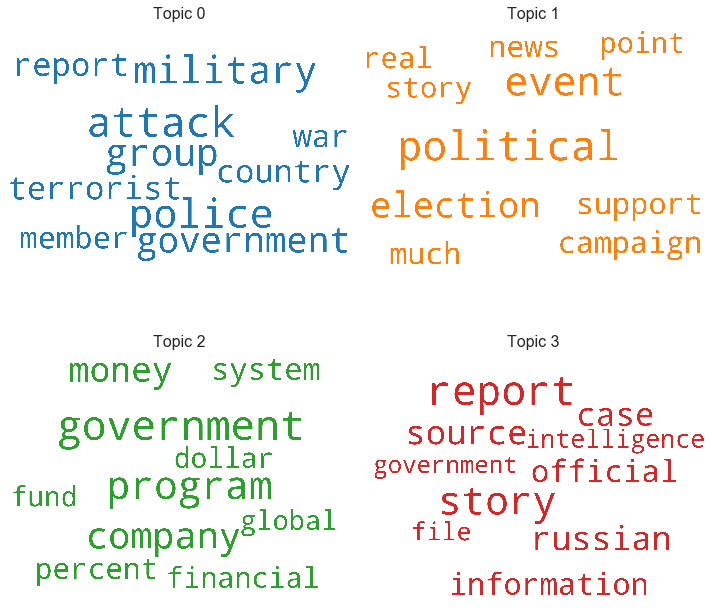

In [10]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

## Word Counts of Topic Key Words

1. **Topic 0 - Military/War** -`Blue`
2. **Topic 1 - Elections/Presidential Campaigns** - `Orange`
3. **Topic 3 - Finance/Governmental Policies** - `Green`
4. **Topic 4 - Media** - `Red`

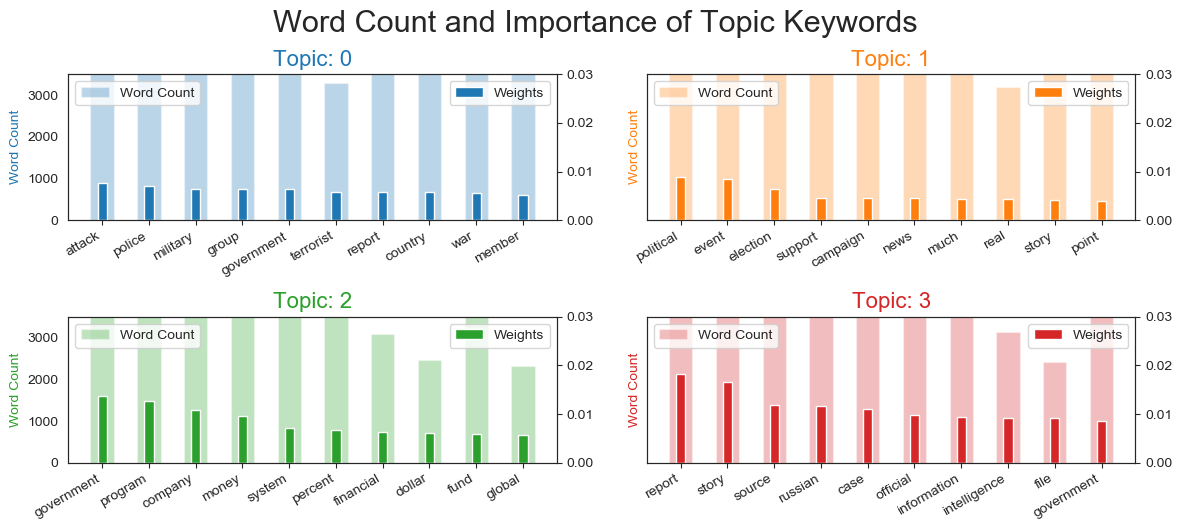

In [11]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(12,5), sharey=True, dpi=100)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

## Sentence Chart Coloured by Topic

1. **Topic 0 - Military/War** - `Blue`
2. **Topic 1 - Elections/Presidential Campaigns** - `Orange`
3. **Topic 3 - Finance/Governmental Policies** - `Green`
4. **Topic 4 - Media** - `Red`

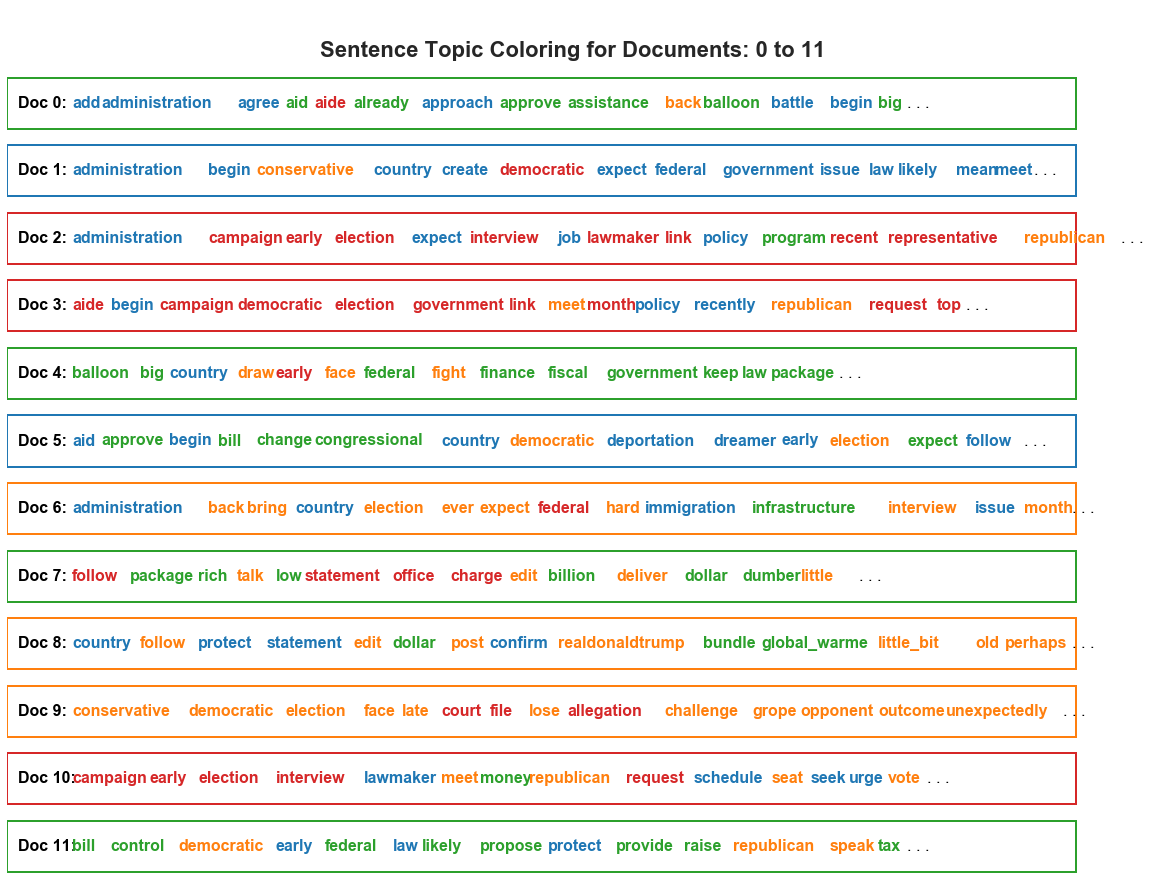

In [12]:
# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=lda_model, corpus=corpus, start = 0, end = 13):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(16, (end-start)*0.95))       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart()    

## Most Discussed Topic in Documents

1. Number of documents for each topic by assigning document to the topic that has the most weight
2. Number of documents for each topic by summing up actual weight contribution of each topic to respective documents

In [13]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

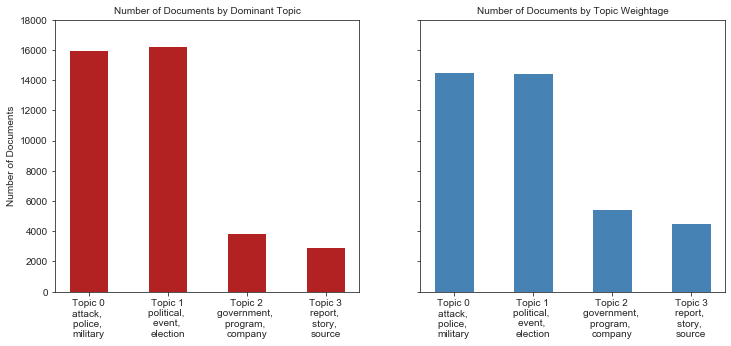

In [14]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 18000)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()

## LDA Visualisation

In [15]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.067970  0.062497       1        1  36.968136
1      0.128961 -0.290701       2        1  36.343651
2     -0.277746  0.015627       3        1  15.512940
3      0.216755  0.212577       4        1  11.175275, topic_info=                 Term          Freq         Total Category  logprob  loglift
322            report  21197.000000  21197.000000  Default  30.0000  30.0000
509             story  15488.000000  15488.000000  Default  29.0000  29.0000
60         government  24934.000000  24934.000000  Default  28.0000  28.0000
110           program   9894.000000   9894.000000  Default  27.0000  27.0000
666              case   9688.000000   9688.000000  Default  26.0000  26.0000
223          official  10821.000000  10821.000000  Default  25.0000  25.0000
1733            event  14019.000000  14019.000000  Default  24.0000  24.0000
41           election  14647.000000  14647.000000  Default  23.0000  23.0000
943            source   7008.000000   7008.000000  Default  22.0000  22.0000
409           company   8005.000000   8005.000000  Default  21.0000  21.0000
314         political  17394.000000  17394.000000  Default  20.0000  20.0000
382           russian   5939.000000   5939.000000  Default  19.0000  19.0000
96              money   6783.000000   6783.000000  Default  18.0000  18.0000
220              news  11454.000000  11454.000000  Default  17.0000  17.0000
20           campaign  11303.000000  11303.000000  Default  16.0000  16.0000
831            police  12100.000000  12100.000000  Default  15.0000  15.0000
95           military  10978.000000  10978.000000  Default  14.0000  14.0000
115            public  13976.000000  13976.000000  Default  13.0000  13.0000
365       information   4844.000000   4844.000000  Default  12.0000  12.0000
293            former   7211.000000   7211.000000  Default  11.0000  11.0000
366      intelligence   4842.000000   4842.000000  Default  10.0000  10.0000
187              file   4676.000000   4676.000000  Default   9.0000   9.0000
4578        terrorist  10023.000000  10023.000000  Default   8.0000   8.0000
240           release   6360.000000   6360.000000  Default   7.0000   7.0000
1758           attack  13720.000000  13720.000000  Default   6.0000   6.0000
1607              war   9476.000000   9476.000000  Default   5.0000   5.0000
320          question   7631.000000   7631.000000  Default   4.0000   4.0000
53            federal   8314.000000   8314.000000  Default   3.0000   3.0000
105           percent   4825.000000   4825.000000  Default   2.0000   2.0000
864             force   8697.000000   8697.000000  Default   1.0000   1.0000
831            police  12099.889648  12100.382812   Topic1  -4.9421   0.9951
95           military  10978.379883  10978.894531   Topic1  -5.0394   0.9951
4578        terrorist  10022.725586  10023.226562   Topic1  -5.1304   0.9951
1607              war   9475.696289   9476.247070   Topic1  -5.1866   0.9951
864             force   8696.890625   8697.405273   Topic1  -5.2723   0.9951
573          security   8582.790039   8583.333984   Topic1  -5.2855   0.9951
3230             kill   7064.788086   7065.291016   Topic1  -5.4802   0.9950
4576           syrian   6539.186035   6539.688965   Topic1  -5.5575   0.9950
795              isis   6152.840332   6153.342285   Topic1  -5.6184   0.9950
1380        operation   6742.013672   6742.640625   Topic1  -5.5269   0.9950
768            target   5259.721191   5260.261230   Topic1  -5.7752   0.9950
3035          western   5206.241699   5206.786621   Topic1  -5.7854   0.9950
4811           terror   4639.816895   4640.331055   Topic1  -5.9006   0.9950
4287           weapon   4605.290039   4605.800781   Topic1  -5.9081   0.9950
1822           threat   4493.183105   4493.691895   Topic1  -5.9327   0.9950
276             carry   4530.834961   4531.356934   Topic1  -5.9244   0.9950
843           

## Saving Dataframe

In [16]:
# Get a sense of the cleaned data frame

display(df_dominant_topic.head())
print(df_dominant_topic.info())
print()
print(df_dominant_topic.shape)

import pickle
df_dominant_topic.to_pickle("dftm.pkl")

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,2.0,0.5002,"government, program, company, money, system, percent, financial, dollar, fund, global","[head, conservative, republican, faction, vote, month, huge, expansion, national, debt, fiscal, ..."
1,1,0.0,0.8397,"attack, police, military, group, government, terrorist, report, country, war, member","[allow, first, enlist, military, start, order, federal, court, decide, appeal, ruling, block, tr..."
2,2,3.0,0.5570,"report, story, source, russian, case, official, information, intelligence, file, government","[investigation, link, election, campaign, interference, administration, ally, republican, lawmak..."
3,3,3.0,0.6355,"report, story, source, russian, case, official, information, intelligence, file, government","[australian, diplomat, political, democratic, presidential, candidate, report, drive, factor, fb..."
4,4,2.0,0.6006,"government, program, company, money, system, percent, financial, dollar, fund, global","[charge, much, ship, package, pick, fight, online, retail_giant, criticize, post, office, lose, ..."


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39080 entries, 0 to 39079
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Document_No         39080 non-null  int64  
 1   Dominant_Topic      39080 non-null  float64
 2   Topic_Perc_Contrib  39080 non-null  float64
 3   Keywords            39080 non-null  object 
 4   Text                39080 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 1.5+ MB
None

(39080, 5)
